In [1]:
import collections, itertools, json, re, os, sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
def strip_config(d):
    if not isinstance(d, dict):
        return d
    return {k: strip_config(v) for k, v in d.items() if k != 'config'}

game_series_states = []

line_re = '.* INFO  service.GamesService  (\{.*\})'
with open(Path.cwd() / 'data' / 'application-20200607.log') as f:
    for line in tqdm(f):
        game_series_state = re.match(line_re, line)
        if game_series_state is not None:
            state = json.loads(game_series_state.group(1))
            state = strip_config(state)
            game_series_states.append(state)
game_series_states = [gss for gss in game_series_states 
                      if gss['currentGame'] is not None and not any(p.get('isAI', True) for p in gss['players'])]
print(f'Found {len(game_series_states)} game state info logs')


Found 6115 game state info logs


In [3]:
game_series_states[2000]

{'id': '5a8207f6-e948-4333-a9f9-85f4a4033680',
 'version': 1163,
 'players': [{'id': '2af1a3c4-f223-4564-bfa9-f85e922cff69',
   'name': 'Max\U0001f9a6',
   'isAI': False},
  {'id': 'b49ca465-7379-4c10-9cd7-2a7100689cbf',
   'name': 'Paupau 🦕',
   'isAI': False},
  {'id': 'fa7366eb-c0fe-430c-87d1-6a0ee806c49c',
   'name': 'Lauron 🦛',
   'isAI': False}],
 'state': {'state': 'gameIsRunning'},
 'currentGame': {'version': 10,
  'players': [{'id': '2af1a3c4-f223-4564-bfa9-f85e922cff69',
    'cards': [{'id': 'H9', 'gameRepresentation': ['♥', '9'], 'endValue': 9},
     {'id': 'C10', 'gameRepresentation': ['♣', '10'], 'endValue': 10},
     {'id': 'H3', 'gameRepresentation': ['♥', '3'], 'endValue': 3},
     {'id': 'HJ', 'gameRepresentation': ['♥', 'J'], 'endValue': 10},
     {'id': 'CJ', 'gameRepresentation': ['♣', 'J'], 'endValue': 10}]},
   {'id': 'b49ca465-7379-4c10-9cd7-2a7100689cbf',
    'cards': [{'id': 'HQ', 'gameRepresentation': ['♥', 'Q'], 'endValue': 10},
     {'id': 'C4', 'gameReprese

In [4]:
by_game = collections.defaultdict(list)
game_counter = collections.defaultdict(int)
turn_counter = collections.defaultdict(int)
known_cards = collections.defaultdict(set)
fresh_drawn = collections.defaultdict(lambda: True)
game_player_turn = set()

for state in game_series_states:
    series_id = state['id']
    game = state['currentGame']
    if game['version'] == 1:
        game_counter[series_id] += 1
    game_id = (series_id, game_counter[series_id])
    
    if game['lastAction'] is not None:
        action_player = game['lastAction']['player']
        action = game['lastAction']['gameAction']
        action_fresh_drawn = False
        if action['type'] == 'drawn' and action['source'] != 'deck':
            known_cards[(game_id, action_player)].add(action['source'])
        if action['type'] == 'drawn':
            action_fresh_drawn = True
        elif action['type'] == 'thrown':
            for card in action['cards']:
                known_cards[(game_id, action_player)].discard(card['id'])
        elif action['type'] == 'drawThrown':
            known_cards[(game_id, action_player)].discard(action['card']['id'])
        else:
            print(f'Unknown action: {action}')
        fresh_drawn[(game_id, action_player)] = action_fresh_drawn
    
    turn = turn_counter[game_id] // len(game['players']) + 1
    gpt = (game_id, game['currentPlayer'], turn)
    if game['nextAction'] == 'throw' and gpt not in game_player_turn:
        game['turn'] = turn
        game['knownCards'] = {player['id']: known_cards[game_id, player['id']] for player in state['players']}
        game['freshDrawn'] = {player['id']: fresh_drawn[game_id, player['id']] for player in state['players']}
        turn_counter[game_id] += 1
        by_game[game_id].append(game)
print(f'Found {len(by_game)} games')

list(by_game.values())[1][4]

Found 208 games


{'version': 10,
 'players': [{'id': 'e2e251cf-853e-498d-8722-3cd68289780a',
   'cards': [{'id': 'D3', 'gameRepresentation': ['♦', '3'], 'endValue': 3},
    {'id': 'H7', 'gameRepresentation': ['♥', '7'], 'endValue': 7},
    {'id': 'H9', 'gameRepresentation': ['♥', '9'], 'endValue': 9},
    {'id': 'SA', 'gameRepresentation': ['♠', 'A'], 'endValue': 1}]},
  {'id': '664eb96d-8001-4097-b3a3-f4cdebc27c4a',
   'cards': [{'id': 'J3', 'gameRepresentation': ['☆', 'J'], 'endValue': 0},
    {'id': 'C2', 'gameRepresentation': ['♣', '2'], 'endValue': 2},
    {'id': 'S6', 'gameRepresentation': ['♠', '6'], 'endValue': 6},
    {'id': 'C7', 'gameRepresentation': ['♣', '7'], 'endValue': 7},
    {'id': 'HJ', 'gameRepresentation': ['♥', 'J'], 'endValue': 10}]},
  {'id': '54f4882d-7dfd-4c08-8299-2b583f015723',
   'cards': [{'id': 'S4', 'gameRepresentation': ['♠', '4'], 'endValue': 4},
    {'id': 'S10', 'gameRepresentation': ['♠', '10'], 'endValue': 10},
    {'id': 'H10', 'gameRepresentation': ['♥', '10'], '

In [5]:
class Index:
    def __init__(self):
        self.ind2item = {}
        self.item2ind = {}
    
    def store(self, item):
        ind = len(self.ind2item)
        self.ind2item[ind] = item
        self.item2ind[item] = ind
    
    def __contains__(self, item):
        return item in self.item2ind
       
    def __getitem__(self, key):
        if not key in self.item2ind:
            self.store(key)
        return self.item2ind[key]
    
test_index = Index()
assert(not 'a' in test_index)
assert(test_index['a'] == 0)
assert('a' in test_index)
assert(test_index['b'] == 1)
assert(test_index.ind2item == {0: 'a', 1: 'b'})
assert(test_index.item2ind == {'a': 0, 'b': 1})

In [6]:
def card_value(card_id):
    if card_id[0] == 'J':
        return 0
    elif card_id[1] == 'A':
        return 1
    elif card_id[1] in ['J', 'Q', 'K']:
        return 10
    else:
        return int(card_id[1:])

assert(card_value("CA") == 1)
assert(card_value("J2") == 0)
assert(card_value("H10") == 10)
assert(card_value("DK") == 10)

In [7]:
games_index = Index()
players_index = Index()
known_cards = collections.defaultdict(set)

by_player = []
for game, states in by_game.items():
    game_id = games_index[game]
    for state in states:
        for player in state['players']:
            cards = player['cards']
            game_id = games_index[game]
            player_id = players_index[player['id']]
            points = sum([card['endValue'] for card in cards])
            known = state['knownCards'][player['id']]
            fresh = state['freshDrawn'][player['id']]
            by_player.append({
                'game': game_id,
                'player': player_id,
                'num_players': len(state['players']),
                'turn': state['turn'],
                'num_cards': len(cards),
                'known_cards': known,
                'points_hand': points,
                'points_per_card': points / len(cards) if points > 0 else 0,
                'points_per_card_unknown': (points - sum(card_value(card) for card in known)) / (len(cards) - len(known)) if len(cards) - len(known) > 0 else 0,
                'fresh_drawn': int(fresh)
            })
print(f'Found {len(by_player)} game/player/version data points')
by_player = pd.DataFrame(by_player).drop_duplicates(['game', 'player', 'turn'])
by_player.head(10)

Found 7445 game/player/version data points


,game,player,num_players,turn,num_cards,known_cards,points_hand,points_per_card,points_per_card_unknown,fresh_drawn
0,0,0,3,1,4,{},24,6.000000,6.000000,1
1,0,1,3,1,5,{},22,4.400000,4.400000,1
2,0,2,3,1,5,{},22,4.400000,4.400000,1
9,0,0,3,2,3,{},20,6.666667,6.666667,1
10,0,1,3,2,5,{},19,3.800000,3.800000,1
11,0,2,3,2,5,{},19,3.800000,3.800000,1
18,0,0,3,3,3,{},16,5.333333,5.333333,1
19,0,1,3,3,3,{},9,3.000000,3.000000,1
20,0,2,3,3,5,{},19,3.800000,3.800000,1
27,0,0,3,4,2,{},14,7.000000,7.000000,1


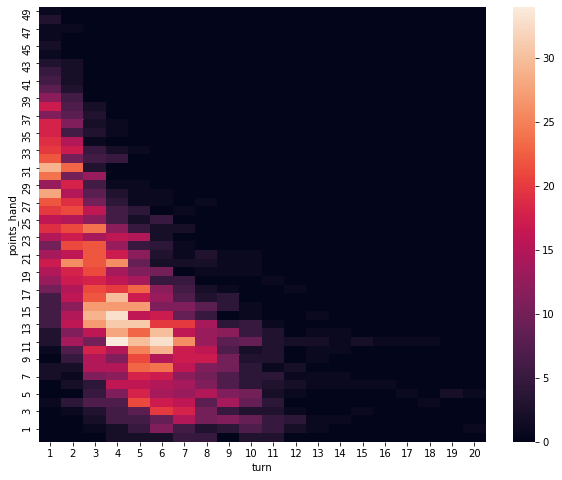

In [8]:
fig = plt.Figure(figsize=(10, 8))
ax = fig.gca()
heatmap_data = by_player.pivot_table(index='points_hand', columns='turn', values='num_cards', aggfunc=len).fillna(0).iloc[::-1]
_ = sns.heatmap(heatmap_data, ax=ax)
fig

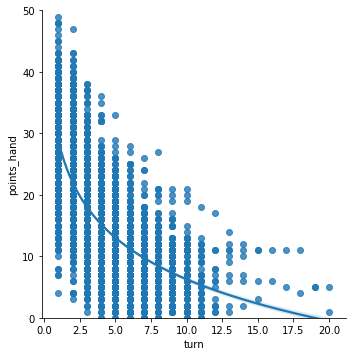

In [9]:
ax = sns.lmplot(x='turn', logx=True, y='points_hand', data=by_player)
_ = ax.set(ylim=(0, 50))

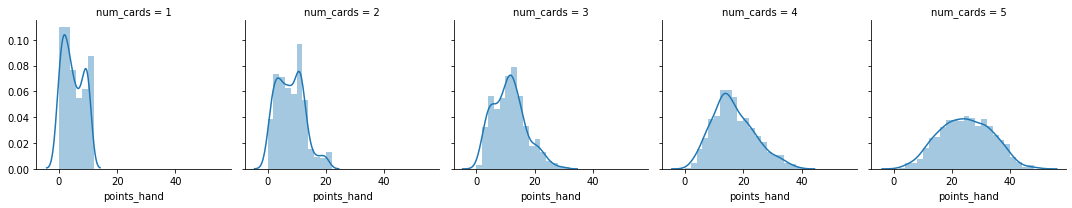

In [10]:
g = sns.FacetGrid(by_player[by_player['num_cards'] > 0], col='num_cards')
g.map(sns.distplot, 'points_hand', bins=np.arange(0, 50, 2))

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(*args, **kwargs):
    return mean_squared_error(*args, **kwargs, squared=False)

In [12]:
games = pd.Series(by_player['game'].unique())
train_games = set(games.sample(round(len(games) * 0.75), random_state=1234))
test_games = set(games) - train_games
print(f'Sampled {len(train_games)} games for training, {len(test_games)} games for testing')

Sampled 156 games for training, 52 games for testing


In [13]:
features = by_player.copy()
features['log_turn'] = np.log(features['turn'])
# features['1/turn'] = 1/features['turn']
# features['num_cards^2'] = features['num_cards']**2

features_train = features[features['game'].isin(train_games)].reset_index(drop=True)
features_test = features[features['game'].isin(test_games)].reset_index(drop=True)
print(f'Train size: {len(features_train)}, test size: {len(features_test)}')

feature_names = ['log_turn', 'num_cards']
# feature_names = ['log_turn', '1/turn', 'num_cards', 'num_players', 'fresh_drawn']
target_name = 'points_hand'

X_train = features_train[feature_names]
X_test  = features_test[feature_names]
y_train = features_train[target_name].values.reshape(-1, 1) # for scaler
y_test  = features_test[target_name].values

pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('predictor', LinearRegression())])

y_scaler = MinMaxScaler()
y_scaler.fit(np.arange(51).reshape(-1, 1))
y_train_scaled = y_scaler.transform(y_train).reshape(-1)

pipeline.fit(X_train, y_train_scaled)

pred_scaled = pipeline.predict(X_test)
pred = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(-1)

print(f'MAE linear regression:          {mean_absolute_error(y_test, pred):.4f}')
print(f'Always predicting mean:         {mean_absolute_error(y_test, np.zeros(len(y_test)) + np.mean(y_test)):.4f}')
print(f'Always predictiong 4*num_cards: {mean_absolute_error(y_test, 4 * X_test["num_cards"]):.4f}')

Train size: 2468, test size: 870
MAE linear regression:          4.6580
Always predicting mean:         7.8066
Always predictiong 4*num_cards: 5.7149


In [14]:
pd.DataFrame([{'feature': 'intercept', 'weight': pipeline['predictor'].intercept_}] + [
    {'feature': feat, 'weight': weight}
    for feat, weight 
    in zip(feature_names, pipeline['predictor'].coef_)
])

,feature,weight
0,intercept,0.255401
1,log_turn,-0.383506
2,num_cards,0.316811


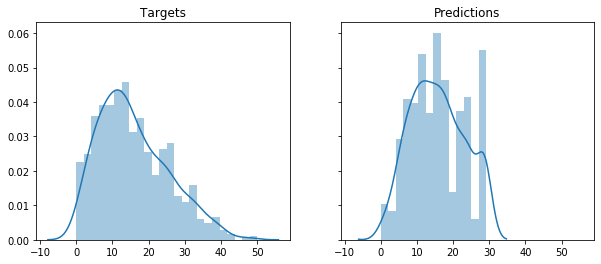

In [15]:
fig = plt.figure(figsize=(10,4))
ax1, ax2 = fig.subplots(ncols=2, sharex=True, sharey=True)
_ = sns.distplot(y_test, ax=ax1, bins=np.linspace(0,50,25))
_ = ax1.set_title('Targets')
_ = sns.distplot(pred, ax=ax2, bins=np.linspace(0,50,25))
_ = ax2.set_title('Predictions')

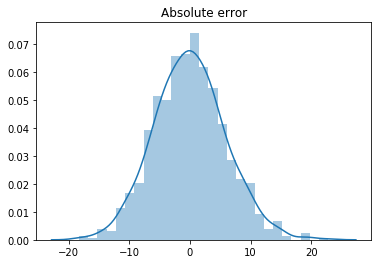

In [16]:
error = y_test - pred
ax = sns.distplot(error)
_ = ax.set_title('Absolute error')

In [17]:
n_samples = 5
sorted_by_error_size = np.argsort(error)

ind = sorted_by_error_size
big_error_samples = features_test.loc[ind]
big_error_samples['prediction'] = pred[ind]
big_error_samples['error'] = error[ind]
big_error_samples[big_error_samples['turn'] > 5]

,game,player,num_players,turn,num_cards,known_cards,points_hand,points_per_card,points_per_card_unknown,fresh_drawn,log_turn,prediction,error
336,53,5,3,6,5,{J1},5,1.000000,1.250000,1,1.791759,17.141757,-12.141757
793,175,14,2,6,4,{},3,0.750000,0.750000,1,1.791759,13.973648,-10.973648
795,175,14,2,7,4,{},3,0.750000,0.750000,1,1.945910,12.986950,-9.986950
462,84,9,2,7,3,{J3},0,0.000000,0.000000,1,1.945910,9.818841,-9.818841
188,34,7,3,6,3,{},2,0.666667,0.666667,0,1.791759,10.805539,-8.805539
...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,172,13,2,11,1,{},10,10.000000,10.000000,1,2.397895,0.589527,9.410473
31,2,1,3,11,1,{},10,10.000000,10.000000,1,2.397895,0.589527,9.410473
209,37,7,3,7,2,{D2},18,9.000000,16.000000,1,1.945910,6.650732,11.349268
421,76,8,2,6,3,{},23,7.666667,7.666667,1,1.791759,10.805539,12.194461


In [18]:
grid = pd.DataFrame([{'turn': t, 'num_cards': c} for t in range(1, 51) for c in range(1, 6)])
grid['log_turn'] = np.log(grid['turn'])
grid['prediction'] = y_scaler.inverse_transform(pipeline.predict(grid[feature_names]).reshape(-1, 1)).reshape(-1)
grid.sample(5)

,turn,num_cards,log_turn,prediction
150,31,1,3.433987,-6.042360
38,8,4,2.079442,12.132233
140,29,1,3.367296,-5.615477
222,45,3,3.806662,-2.091588
34,7,5,1.945910,16.155059


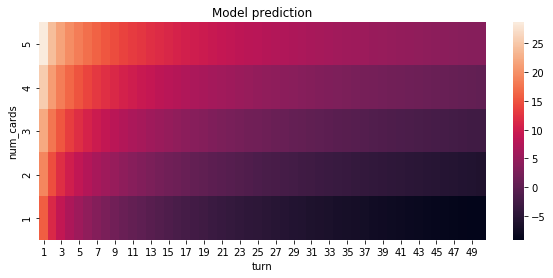

In [19]:

fig = plt.Figure(figsize=(10, 4))
ax = fig.gca()
heatmap_data = grid.pivot_table(index='num_cards', columns='turn', values='prediction').fillna(0).iloc[::-1]
_ = sns.heatmap(heatmap_data, ax=ax)
_ = ax.set_title('Model prediction')
fig